In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf  
from statsmodels.tsa.ar_model import AutoReg
import math

In [3]:
stock = yf.download("^GSPC", start="1990-01-01")

# Wir arbeiten nur mit dem Schlusskurs
df = stock[['Close']].copy()
df.columns = df.columns.get_level_values(0) # get rid of the multiindex
df = df.rename(columns={'Close': 'Werte'})
df.head()

/tmp/ipykernel_907811/3108302745.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download("^GSPC", start="1990-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Werte
Date,
1990-01-02,359.690002
1990-01-03,358.760010
1990-01-04,355.670013
1990-01-05,352.200012
1990-01-08,353.790009


___
**2. Visuelle Analyse & das Problem des Trends**

Zuerst visualisieren wir die Zeitreihe. Um das exponentielle Wachstum besser darzustellen, verwenden wir eine logarithmische y-Achse (logy=True), genau wie im Vorlesungs-Notebook.

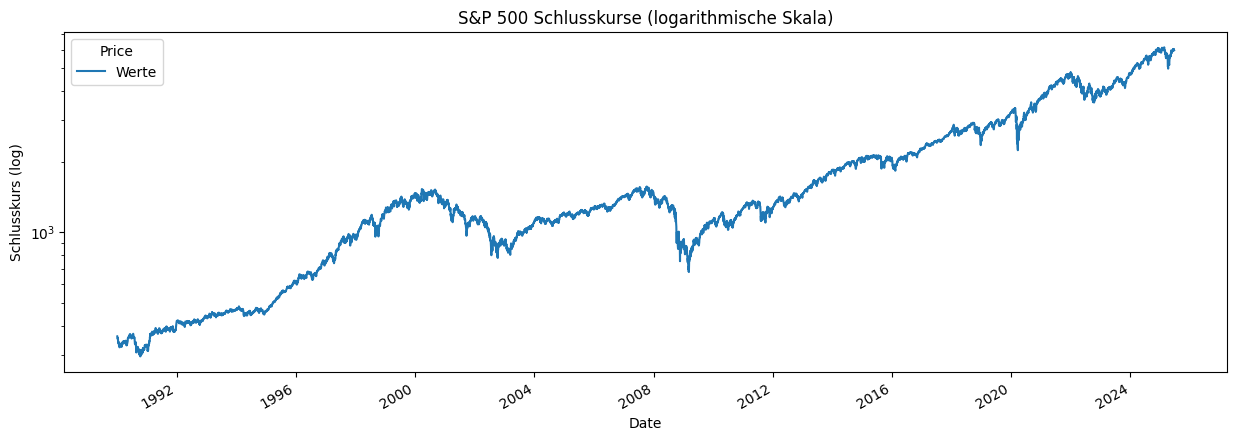

In [4]:
df.plot(figsize=(15,5), logy=True, title='S&P 500 Schlusskurse (logarithmische Skala)')
plt.ylabel('Schlusskurs (log)')
plt.show()

Die Grafik zeigt einen klaren, langfristigen Aufwärtstrend. Die Zeitreihe ist also nicht stationär.

Um den Effekt des Trends zu verdeutlichen, erstellen wir einen Scatter-Plot, der den heutigen Wert (Werte) gegen den Wert des Vortages (Vortag) aufträgt. Die Punkte werden nach dem Datum eingefärbt.

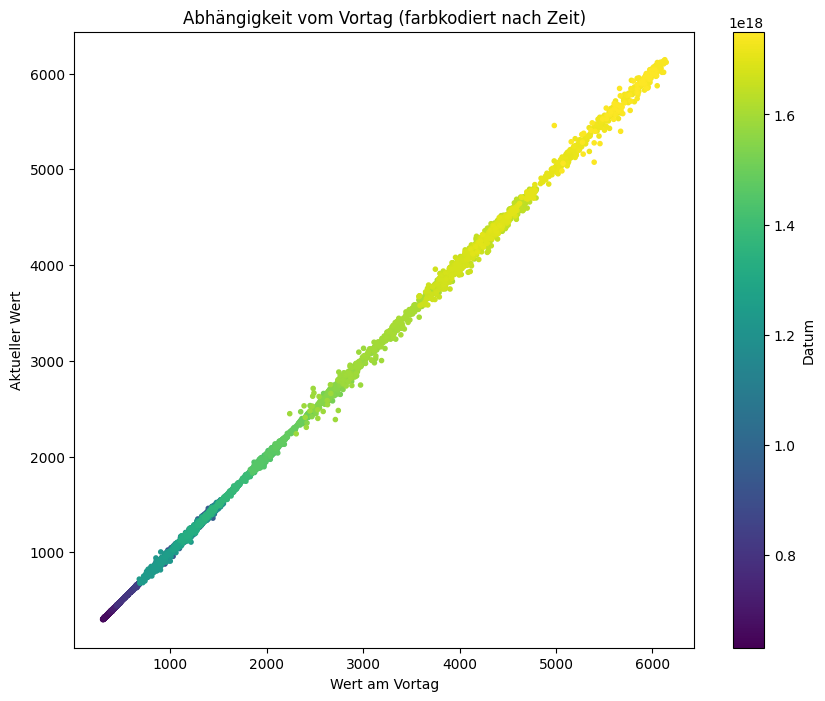

Korrelation zwischen heutigem Wert und Vortageswert:
Price      Werte    Vortag
Price                     
Werte   1.000000  0.999831
Vortag  0.999831  1.000000


In [5]:
df['Vortag'] = df['Werte'].shift(1)

# Scatter-Plot erstellen
plt.figure(figsize=(10, 8))
plt.scatter(df.Vortag, df.Werte, c=df.index, marker='.')
plt.xlabel('Wert am Vortag')
plt.ylabel('Aktueller Wert')
plt.title('Abhängigkeit vom Vortag (farbkodiert nach Zeit)')
plt.colorbar(label="Datum")
plt.show()

# Korrelation berechnen
print("Korrelation zwischen heutigem Wert und Vortageswert:")
print(df[['Werte', 'Vortag']].corr())

**Interpretation**

Die Punkte bilden keine einzelne, zentrierte Wolke, sondern wandern von links unten (frühe Jahre, niedrige Kurse) nach rechts oben (heutige Zeit, hohe Kurse). Die extrem hohe Korrelation von > 0.99 kommt fast ausschließlich durch den gemeinsamen Trend zustande und überdeckt die eigentliche, kurzfristige Dynamik. Für eine sinnvolle Modellierung muss dieser Trend entfernt werden.
___

**3. Trendbereinigung durch relative Änderungen**

Im Vorlesungs-Notebook wird hierfür eine gängige Methode aus der Finanzwelt verwendet: statt der absoluten Werte betrachten wir die täglichen relativen Änderungen (Renditen).


Diese transformierte Zeitreihe sollte keinen Trend mehr aufweisen.

Price            Werte      Vortag
Date                              
1990-01-03  358.760010  359.690002
1990-01-04  355.670013  358.760010
1990-01-05  352.200012  355.670013
1990-01-08  353.790009  352.200012
1990-01-09  349.619995  353.790009


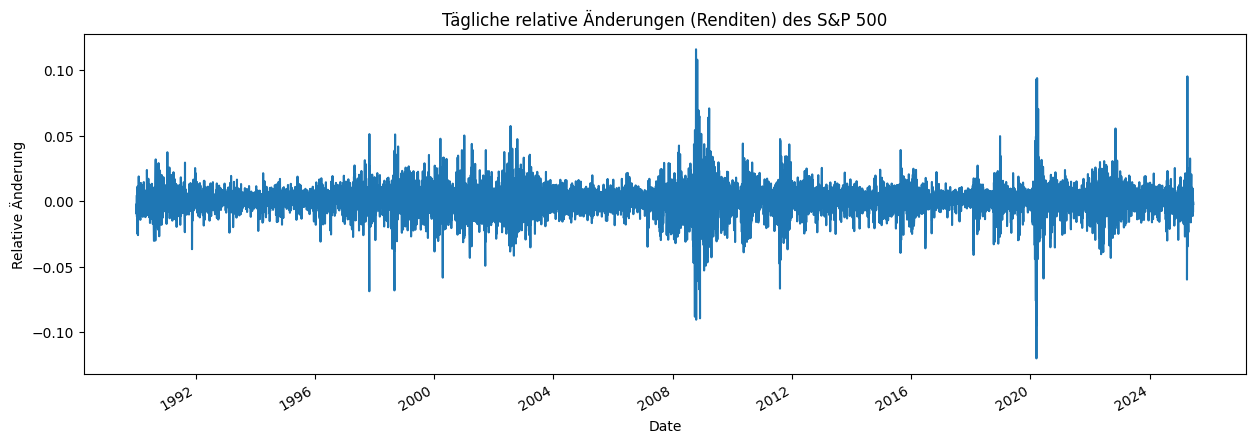

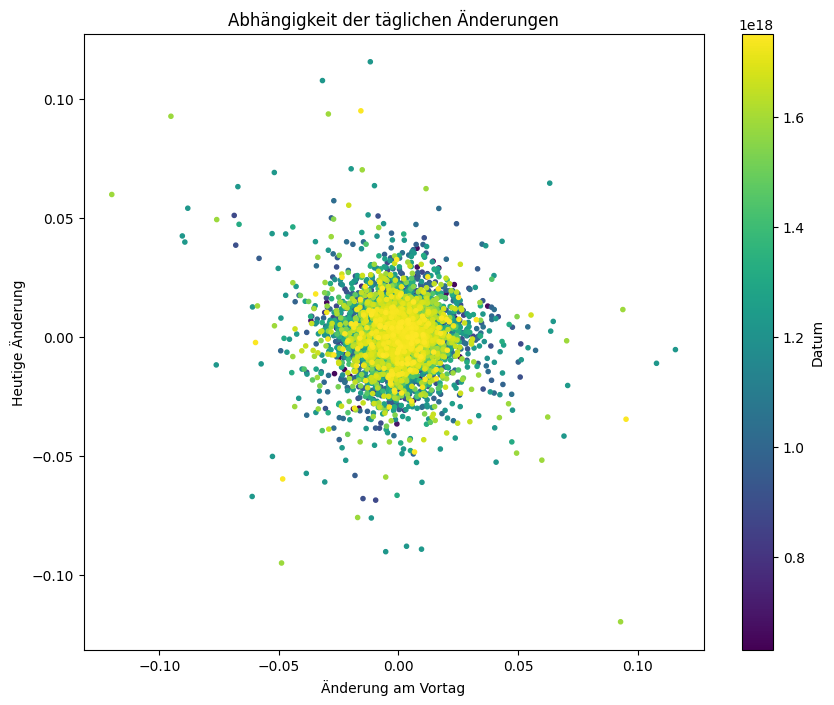

In [6]:
tb = df[['Werte', 'Vortag']].copy().dropna()
print(tb.head())
tb['change'] = tb['Werte'] / tb['Vortag'] - 1

# Plot der bereinigten Zeitreihe
tb['change'].plot(figsize=(15,5), title='Tägliche relative Änderungen (Renditen) des S&P 500')
plt.ylabel('Relative Änderung')
plt.show()

# Scatter-Plot der bereinigten Werte
tb['Change_am_Vortag'] = tb['change'].shift(1)
plt.figure(figsize=(10, 8))
plt.scatter(tb.Change_am_Vortag, tb.change, c=tb.index, marker='.')
plt.xlabel('Änderung am Vortag')
plt.ylabel('Heutige Änderung')
plt.title('Abhängigkeit der täglichen Änderungen')
plt.colorbar(label="Datum")
plt.show()

**Interpretation**

Die neue Zeitreihe schwankt nun um den Wert 0 und hat keinen sichtbaren Trend mehr. Der Scatter-Plot zeigt eine zentrierte Wolke ohne zeitliche Drift. Die IID-Annahme ist für diese transformierte Reihe wesentlich plausibler.
___

**4. Erstes AR(2)-Modell**

Nun testen wir, wie gut ein einfaches autoregressives Modell der Ordnung 2 (AR(2)) die Zeitreihe vorhersagen kann. Wir wenden es einmal auf die Originaldaten und einmal auf die bereinigten Daten an, um den Effekt des Trends zu sehen.

Bezug zur Vorlesung: Wir nutzen die AutoReg-Klasse aus statsmodels und definieren eine Hilfsfunktion, um den Prozess zu vereinfachen, genau wie im Vorlesungs-Notebook.

In [10]:
df.index

DatetimeIndex(['1990-01-02', '1990-01-03', '1990-01-04', '1990-01-05',
               '1990-01-08', '1990-01-09', '1990-01-10', '1990-01-11',
               '1990-01-12', '1990-01-15',
               ...
               '2025-06-06', '2025-06-09', '2025-06-10', '2025-06-11',
               '2025-06-12', '2025-06-13', '2025-06-16', '2025-06-17',
               '2025-06-18', '2025-06-20'],
              dtype='datetime64[ns]', name='Date', length=8933, freq=None)

In [8]:
def train_eval_AR(ser, lags=2):
    """Passt ein AR-Modell an und evaluiert es."""
    data = ser.dropna().copy()
    
    # AR-Modell fitten
    model = AutoReg(data, lags=lags)
    model_fit = model.fit()
    
    # In-Sample Vorhersagen erstellen
    predictions = model_fit.predict(start=0, end=len(data), dynamic=False)
    predicted_values = predictions.values[:len(data)]
    

    # Metriken berechnen und ausgeben
    rmse = math.sqrt(((data - predicted_values)**2).mean())
    variance_explained = 1 - (data - predicted_values).var() / data.var()
    
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Standardabweichung der Daten: {data.std():.6f}")
    print(f"Erklärte Varianz (R²): {variance_explained:.4f}")
    
    return pd.DataFrame({'True_Values': ser, 'Predicted_Values': predicted_values}), model_fit

# --- Schritt 7: Modell auf Originaldaten anwenden ---
print("--- Modell auf Original-Zeitreihe ---")
train_eval_AR(df.Werte)

print("\n--- Modell auf trendbereinigter Zeitreihe (relative Änderungen) ---")
train_eval_AR(tb.change)

--- Modell auf Original-Zeitreihe ---
Root Mean Squared Error (RMSE): 24.311163
Standardabweichung der Daten: 1328.004402
Erklärte Varianz (R²): 0.9997

--- Modell auf trendbereinigter Zeitreihe (relative Änderungen) ---
Root Mean Squared Error (RMSE): 0.011387
Standardabweichung der Daten: 0.011425
Erklärte Varianz (R²): 0.0066


/home/datata1/Documents/dabi2-vorbereitung/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/datata1/Documents/dabi2-vorbereitung/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/datata1/Documents/dabi2-vorbereitung/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/datata1/Documents/dabi2-vorbereitung/.venv/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only Per

(            True_Values  Predicted_Values
 Date                                     
 1990-01-03    -0.002586               NaN
 1990-01-04    -0.008613               NaN
 1990-01-05    -0.009756          0.001157
 1990-01-08     0.004514          0.001329
 1990-01-09    -0.011787          0.000174
 ...                 ...               ...
 2025-06-13    -0.011296          0.000140
 2025-06-16     0.009393          0.001294
 2025-06-17    -0.008352         -0.000206
 2025-06-18    -0.000309          0.000980
 2025-06-20    -0.002179          0.000551
 
 [8932 rows x 2 columns],
 <statsmodels.tsa.ar_model.AutoRegResultsWrapper at 0x78a26d782e40>)

**interpretation der Modellergebnisse**

- Original-Zeitreihe: Das Modell erreicht eine "erklärte Varianz" von 99.9%. Das klingt fantastisch, ist aber irreführend. Das Modell lernt im Grunde nur, den Wert des Vortages vorherzusagen (Y_t
approxY_t−1), was bei einer stark trendbehafteten Reihe sehr gut funktioniert, aber keine echte Prognosekraft für die Änderung hat.
- Trendbereinigte Zeitreihe: Hier zeigt sich die Wahrheit. Das Modell kann nur einen winzigen Bruchteil der Varianz erklären (oft nahe 0). Das bedeutet, die tägliche Änderung des S&amp;P 500 lässt sich mit einem einfachen AR(2)-Modell kaum vorhersagen.

___

**5. Prognosemodi: dynamic=False vs. dynamic=True**

statsmodels bietet zwei wichtige Modi für Vorhersagen, die es zu verstehen gilt.

- dynamic=False (Standard): One-Step-Ahead-Prognose (In-Sample). Zur Vorhersage von Zeitpunkt t werden immer die echten, historischen Werte bis t-1 verwendet. Dies testet, wie gut das Modell die Daten innerhalb des Trainingszeitraums nachbilden kann.

- dynamic=True: Multi-Step-Ahead-Prognose (Out-of-Sample / Extrapolation). Das Modell prognostiziert den ersten Wert nach den Trainingsdaten. Dieser prognostizierte Wert wird dann als Input für die nächste Prognose verwendet, und so weiter. Dies simuliert eine echte Vorhersage in die Zukunft.


/home/datata1/Documents/dabi2-vorbereitung/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/datata1/Documents/dabi2-vorbereitung/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/datata1/Documents/dabi2-vorbereitung/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/datata1/Documents/dabi2-vorbereitung/.venv/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only Per

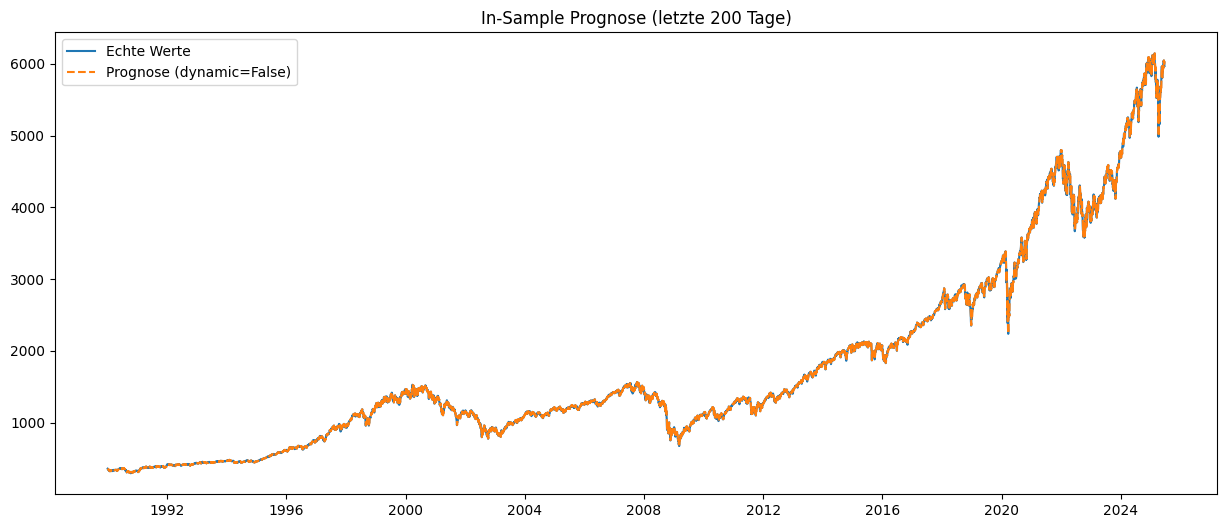

/home/datata1/Documents/dabi2-vorbereitung/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/datata1/Documents/dabi2-vorbereitung/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/datata1/Documents/dabi2-vorbereitung/.venv/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


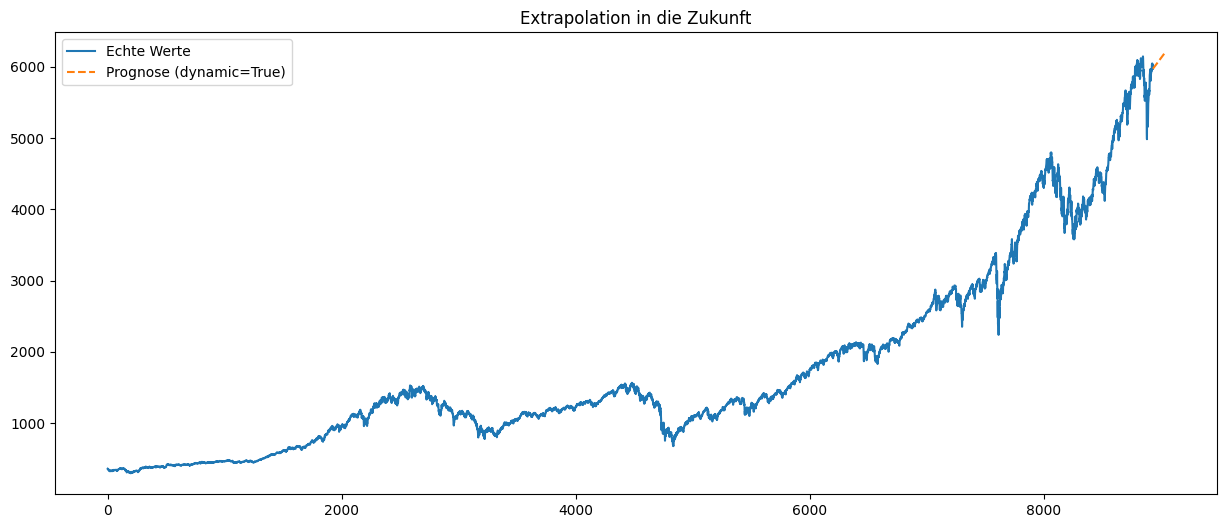

In [9]:
# --- Schritt 8: Prognosemodi visualisieren ---

# Wir nehmen die Originaldaten, um den Effekt klar zu sehen
data = df.Werte.copy()
model_fit = AutoReg(data, lags=2).fit()

# --- Variante 1: dynamic=False ---
pred_in_sample = model_fit.predict(start=0, end=len(data), dynamic=False)
predictions = pred_in_sample.iloc[0:len(data)] 
predictions.index = data.index

plt.figure(figsize=(15, 6))
plt.plot(data, label='Echte Werte')
plt.plot(predictions, label='Prognose (dynamic=False)', linestyle='--')
plt.title('In-Sample Prognose (letzte 200 Tage)')
plt.legend()
plt.show()


# --- Variante 2: dynamic=True ---
# Wir prognostizieren 100 Schritte in die Zukunft
pred_out_of_sample = model_fit.predict(start=len(data), end=len(data)+99, dynamic=True)
data.index = range(len(data))

plt.figure(figsize=(15, 6))
plt.plot(data, label='Echte Werte')
plt.plot(pred_out_of_sample, label='Prognose (dynamic=True)', linestyle='--')
plt.title('Extrapolation in die Zukunft')
plt.legend()
plt.show()

**Interpretation der Prognose-Plots**

- dynamic=False: Die Prognosekurve folgt der echten Kurve sehr eng, oft nur um einen Schritt versetzt. Das bestätigt unsere Vermutung: Das Modell sagt im Grunde "morgen ist es so wie heute".

- dynamic=True: Das Modell setzt einfach den zuletzt gesehenen Trend fort. Es hat keine Fähigkeit, zukünftige Wendepunkte oder komplexere Muster vorherzusagen.